In [38]:
"""
Created on Thu November 10 2022
@author: gaspersechu
Some code excerpts from: simonfilhol

"""

from osgeo import gdal, osr
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import lstsq

In [39]:
# Inputs and parameters
inRas = 'test2.tif'
outRas = 'test2_detrend.tif'

In [40]:
# Read raster to numpy array
def tif2array(fname):
    '''
    Function to read a geotif straight in to a numpy array. Currently tested only for 1 band rasters
    '''
    myRaster=gdal.Open(fname)
    transform = myRaster.GetGeoTransform()
    dx = transform[1]
    dy = transform[5]
    Xsize = myRaster.RasterXSize
    Ysize = myRaster.RasterYSize
    xmin = transform[0]
    xmax = xmin + dx*Xsize
    ymax = transform[3]
    ymin = ymax + dy*Ysize
    data = myRaster.ReadAsArray(0, 0, Xsize, Ysize)
    nodata = myRaster.GetRasterBand(1).GetNoDataValue()
    myRaster = None
    if nodata < -9000:
        data[data < -9000] = np.nan
    elif nodata > 9000:
        data[data > 9000] = np.nan

    return data, dx, dy, transform, Xsize, Ysize, xmin, xmax, ymin, ymax

data, dx, dy, transform, Xsize, Ysize, xmin, xmax, ymin, ymax = tif2array(inRas)

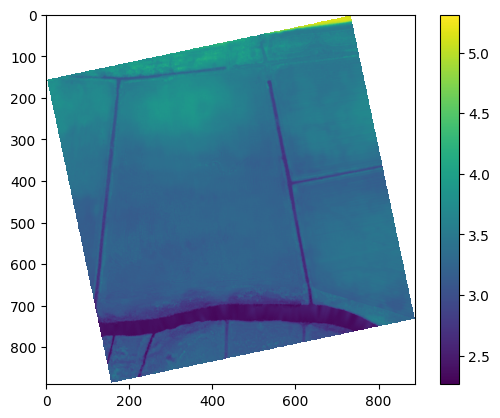

In [41]:
# Visualize raster
def plot_array(mat):
    plt.figure()
    plt.imshow(mat, origin='upper')
    plt.colorbar()
    plt.show()

plot_array(data)

In [42]:
# Create mesh grid covering the domain of the data
X,Y = np.meshgrid(np.arange(xmin, xmax, dx), np.arange(ymin, ymax, -dy))
XX = X.flatten()
YY = Y.flatten()

In [43]:
# Reshape the data
X = np.reshape(XX, (-1, 1))
Y = np.reshape(YY, (-1, 1))
Z = np.reshape(data, (-1, 1))

# Data prep for plane fitting
coords = np.append(X, Y, axis=1)
data_reg = np.append(coords, Z, axis=1)
data_reg = data_reg[~np.isnan(data_reg).any(axis=1)]

In [44]:
# Fitting the linear plane
A = np.c_[data_reg[:,0], data_reg[:,1], np.ones(data_reg.shape[0])]
C,_,_,_ = lstsq(A, data_reg[:,2])    # coefficients

In [45]:
# Calculating residuals from grid plane
Z_plane = np.dot(np.c_[XX, YY, np.ones(XX.shape)], C).reshape(X.shape) # OR Z_plane = C[0]*X + C[1]*Y + C[2]
residuals = Z - Z_plane

In [46]:
# Rotating the plane (parallel)
centroid = np.mean(Z_plane)
m,n = np.shape(Z_plane)
Z_flat = np.full((m, n), centroid)

In [47]:
# Subtraction to get detrended array
Z_detr = residuals + Z_flat

In [48]:
# Reshape detrended raster
Z_detr_reshape = Z_detr.reshape(Ysize, Xsize)

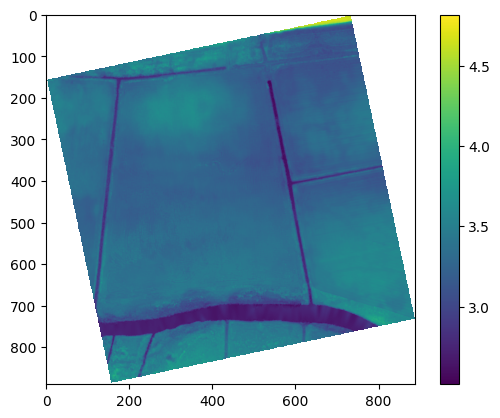

In [49]:
# Visualize raster
def plot_array(mat):
    plt.figure()
    plt.imshow(mat, origin='upper')
    plt.colorbar()
    plt.show()

plot_array(Z_detr_reshape)

In [50]:
# Save raster
def saveArray2rasterTif(fname, array, rasterGeotransform, OutPath, _FillValue=-9999, epsg=25832, 
                        dataType='Float32', compression='LZW', flip_array=False):
    '''
    Save to a GeoTiff file the array
    **saveArray2rasterTif(filename, transform, myArray, OutPath)**
    S. Filhol
    Dependencies: gdal, os, Tkinter, osr
    :param fname:  string of the new file name
    :param array: 2D/3D matrix containing the data to save as a raster file. if 3D array, the shape must be (nx,ny,bands).
    :param rasterGeotransform: Raster geotransform (see gdal help): [Xmin, dx, 0, Ymax, 0, -dy]
    :param _FillValue: default -9999
    :param OutPath: optional. String indicating the path where to save the file 
    :param flip_array: flip the arras vertically. 
    :param epsg: projecton epsg code (change to own locale)
    :return:
    '''

    cwd = os.getcwd()
    os.chdir(OutPath)
    cols = array.shape[1]
    rows = array.shape[0]
    if array.shape.__len__()==3:
        bands = array.shape[2]
    else:
        bands = 1

    if dataType == 'Float32':
        dataType = gdal.GDT_Float64
    elif dataType== 'Int32':
        dataType = gdal.GDT_Int32
    else:
        dataType = gdal.GDT_Float64

    if compression == 'LZW':
        compress = ['COMPRESS=LZW']
    elif compression == 'JPEG':
        compress = ['COMPRESS=JPEG']
    else:
        compress = None

    driver = gdal.GetDriverByName('GTiff')
    outRaster = driver.Create(fname, cols, rows, bands, dataType, options=compress)
    outRaster.SetGeoTransform(rasterGeotransform)
    if bands>1:
        for b in range(1,bands+1):
            print('Saving band: ' + str(b))
            outband = outRaster.GetRasterBand(b)
            outband.SetNoDataValue(_FillValue)
            if flip_array:
                outband.WriteArray(np.flipud(array[:,:,b-1]))
            else:
                outband.WriteArray(array[:,:,b-1])
                outband.FlushCache()
    else:
        outband = outRaster.GetRasterBand(1)
        outband.SetNoDataValue(_FillValue)
        if flip_array:
            outband.WriteArray(np.flipud(array[:,:]))
        else:
            outband.WriteArray(array[:,:])
            outband.FlushCache()
    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromEPSG(epsg)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    print('Array saved to raster')
    os.chdir(cwd)

saveArray2rasterTif(outRas, Z_detr_reshape, transform, os.getcwd(), _FillValue=-9999, epsg=25832, 
                        dataType='Float32', compression='LZW', flip_array=False)

Array saved to raster
